# PREDICCIONES ARIMA

In [15]:
## Imports

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



from utils import read_table_into_dataframe
from utils import create_table_pdf
from utils import  dataframe_to_latex
from utils import dataframe_to_image

In [2]:
### CONNECT TO POSTGRES DATABASE
## AMBA

import psycopg2

# Establish connection parameters
dbname = 'AMBA'
user = 'postgres'
password = 'Ferm1987'
host = 'localhost'  # By default, localhost
port = '5432'  # By default, 5432

# Connect to the PostgreSQL database
try:
    conn = psycopg2.connect(
        dbname=dbname,
        user=user,
        password=password,
        host=host,
        port=port
    )

    # Create a cursor object
    cursor = conn.cursor()

    # Execute a query
    cursor.execute("SELECT version();")
    db_version = cursor.fetchone()
    print("Connected to:", db_version)

    # Commit the transaction
    conn.commit()

except psycopg2.Error as e:
    print("Error connecting to PostgreSQL:", e)

finally:
    # Close the cursor and connection
    if 'cursor' in locals() and cursor is not None:
        cursor.close()
    # if 'conn' in locals() and conn is not None:
    #     conn.close()


Connected to: ('PostgreSQL 16.1, compiled by Visual C++ build 1937, 64-bit',)


In [6]:
# Read vCensosAmba
df = read_table_into_dataframe('public.v_censos_amba')
df=df.sort_values('nam')
df.drop('Superficie', axis=1, inplace=True)
if df is not None:
    print(df)


                nam cod_depto  anio       pob       var       muj   vivpart  \
35  Almirante Brown     06028  1991  450698.0  222042.0  228656.0       NaN   
33  Almirante Brown     06028  2010  552902.0  270247.0  282655.0  156218.0   
32  Almirante Brown     06028  2022  585852.0  281842.0  301779.0  184403.0   
34  Almirante Brown     06028  2001  515556.0  252454.0  263102.0  143543.0   
94       Avellaneda     06035  2001  328980.0  155450.0  173530.0  117200.0   
..              ...       ...   ...       ...       ...       ...       ...   
75  Tres de Febrero     06840  1991  349376.0  167417.0  181959.0       NaN   
6     Vicente López     06861  2001  274082.0  127238.0  146844.0  108947.0   
4     Vicente López     06861  2022  283510.0  131723.0  149903.0  126139.0   
7     Vicente López     06861  1991  289505.0  135426.0  154079.0       NaN   
5     Vicente López     06861  2010  269420.0  125792.0  143628.0  114747.0   

    vivtotal     sup ind_masc dens_pob  
35       N

#### MERGE

## ARIMA

In [13]:
# Check for missing values
missing_values = df.isna().sum()
print("Missing values:\n", missing_values)

df=df.dropna()

# Check for missing values
missing_values = df.isna().sum()
print("Missing values:\n", missing_values)


Missing values:
 nam           0
cod_depto     0
anio          0
pob           6
var           6
muj           6
vivpart      24
vivtotal     24
sup           0
ind_masc      6
dens_pob      6
dtype: int64
Missing values:
 nam          0
cod_depto    0
anio         0
pob          0
var          0
muj          0
vivpart      0
vivtotal     0
sup          0
ind_masc     0
dens_pob     0
dtype: int64


In [14]:


# Load your data and set 'anio' as the index
# df = ...

# Check for stationarity
result = adfuller(df['pob'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] > 0.05:
    print('Series is not stationary. Perform differencing.')
else:
    print('Series is stationary. No differencing needed.')

# If series is not stationary, perform differencing
# df['pob_diff'] = df['pob'].diff().dropna()

#Plot the data
df['pob'].plot()

#Determine ARIMA order (p, d, q) using ACF and PACF plots, or auto-arima functions

# Fit ARIMA model
# model = ARIMA(df['pob'], order=(p, d, q))
# fitted_model = model.fit()

# Make predictions
# forecast = fitted_model.forecast(steps=...)  # Specify the number of future steps to forecast

# Plot the forecasted values
# plt.plot(df.index, df['pob'], label='Observed')
# plt.plot(forecast.index, forecast, label='Forecast', color='red')
# plt.xlabel('Year')
# plt.ylabel('Population')
# plt.title('ARIMA Population Forecast')
# plt.legend()
# plt.show()


ADF Statistic: -3.09238743146041
p-value: 0.02712170602230532
Series is stationary. No differencing needed.


### Determine ARIMA order (p, d, q) using ACF and PACF plots, or auto-arima functions

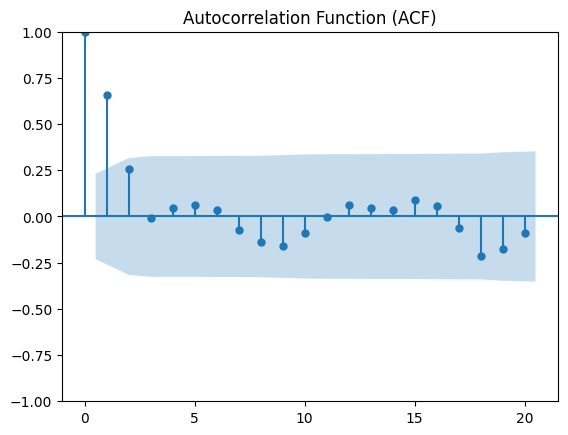

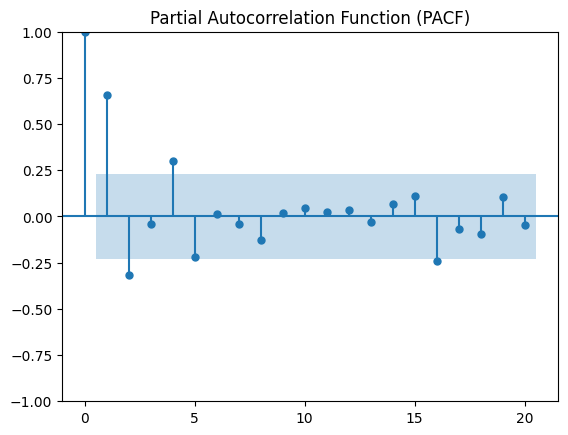

In [16]:
#Determine ARIMA order (p, d, q) using ACF and PACF plots, or auto-arima functions
# Plot ACF
plot_acf(df['pob'], lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plot_pacf(df['pob'], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


In [ ]:
p=1
d=0
q=0

#Fit ARIMA model
model = ARIMA(df['pob'], order=(p, d, q))
fitted_model = model.fit()

#Make predictions
forecast = fitted_model.forecast(steps=10)  # Specify the number of future steps to forecast

#Plot the forecasted values
plt.plot(df.index, df['pob'], label='Observed')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('ARIMA Population Forecast')
plt.legend()
plt.show()

In [ ]:


def fit_arima(df, nam):
    # Filter data for the specific 'nam' value
    df_subset = df[df['nam'] == nam]
    
    # Check if there is sufficient data
    if len(df_subset) < 2:
        return None
    
    # Extract the 'anio' and 'pob' columns for ARIMA modeling
    X = df_subset['anio']
    y = df_subset['pob']
    
    # Fit ARIMA model with order (1, 0, 0)
    model = ARIMA(y, order=(1, 0, 0))
    model_fit = model.fit()
    
    return model_fit

# Iterate over unique values in 'nam' column and fit ARIMA model
arima_models = {}
for nam in df['nam'].unique():
    model_fit = fit_arima(df, nam)
    if model_fit:
        arima_models[nam] = model_fit
        print(f"ARIMA Model for {nam}:")
        print(model_fit.summary())

In [ ]:

# Iterate over each ARIMA model and make predictions
for nam, model_fit in arima_models.items():
    # Make predictions for the next 2 steps (adjust as needed)
    forecast = model_fit.forecast(steps=2)
    
    # Plot the observed data
    plt.plot(df[df['nam'] == nam]['anio'], df[df['nam'] == nam]['pob'], label=f'Observed ({nam})')
    
    # Plot the forecasted values
    plt.plot(df[df['nam'] == nam]['anio'].iloc[-1] + 1 + forecast.index, forecast, label=f'Forecast ({nam})', color='red')

# Add labels and legend
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('ARIMA Population Forecast')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\Fer\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Fer\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Fer\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Fer\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Fer\AppData\Local\Programs\

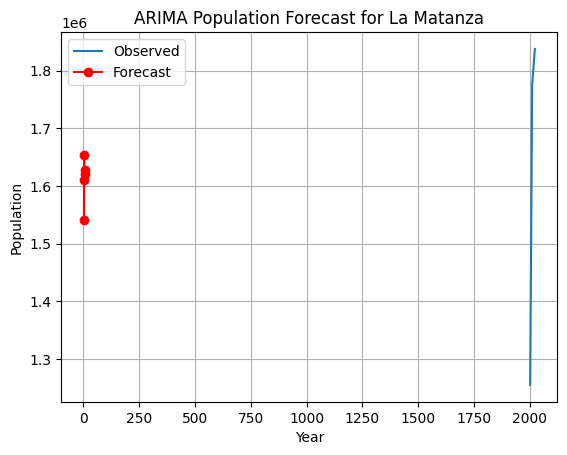

In [24]:
# Filter the DataFrame to create a subset for "La Matanza"
subset_df = df[df['nam'] == "La Matanza"]

# Prepare the time series data
time_series_data = subset_df.set_index('anio')['pob']

# Fit an ARIMA model
model = ARIMA(time_series_data, order=(1,0,0))  # Adjust the order as needed
fitted_model = model.fit()

# Forecast future values
forecast = fitted_model.forecast(steps=5)  # Forecast 5 steps ahead

# Plot the observed data and forecasted values
plt.plot(time_series_data.index, time_series_data, label='Observed')
plt.plot(forecast.index, forecast, label='Forecast', color='red', marker='o')
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('ARIMA Population Forecast for La Matanza')
plt.legend()
plt.grid(True)
plt.show()
